In [1]:
%cd /raid6/home/yokoyama/har-for-or/
import os
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from tqdm import tqdm
from webdataset import WebLoader

from src.data import load_dataset_iterable
from src.model import SQVAE
from src.utils import video, yaml_handler, vis

/raid6/home/yokoyama/har-for-or


/raid6/home/yokoyama/har-for-or/.venv/lib/python3.10/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


In [2]:
model_type = "sqvae"
dataset_num = 3

if dataset_num == 3:
    video_num = 6
    # v = 1
    # v = 3  # book_size 1024, decoder 変更
    v = 4  # book_size 1024, nlayers 6 →　精度向上?
    v = 5  # book_size 128, nlayers 6
elif dataset_num == 4:
    video_num = 9
    v = 1
elif dataset_num == 5:
    video_num = 7
    v = 2

data_root = f"../datasets/dataset{dataset_num:02d}/train/{video_num:02d}"
# data_dirs = sorted(glob(os.path.join(data_root, "*/")))
data_dirs = [data_root]

checkpoint_dir = f"models/individual/{model_type}/version_{v}"

# load config
config_path = f"{checkpoint_dir}/individual-{model_type}.yaml"
config = yaml_handler.load(config_path)

# load classes
path = f"../datasets/dataset{dataset_num:02d}/annotation/classes.txt"
classes = np.loadtxt(path, str, usecols=0, delimiter=",")
classes = [c.title() for c in classes]

In [3]:
gpu_id = 1
device = f"cuda:{gpu_id}"

# load dataset
dataset, n_samples = load_dataset_iterable(data_dirs, "individual", config, False)
dataset = dataset.batched(1)
dataloader = WebLoader(dataset, num_workers=1)

# load model
model = SQVAE(config)
model.configure_model()
model = model.to(device)

checkpoint_path = sorted(glob(f"{checkpoint_dir}/*.ckpt"))[-1]
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [4]:
# # label count
# annotation_path = f"../datasets/dataset{dataset_num:02d}/annotation/role.txt"
# anns = np.loadtxt(annotation_path, str, delimiter=" ", skiprows=1)

# results_tmp = []
# counts = {i: 0 for i in range(5)}
# for batch in tqdm(dataloader, total=n_samples):
#     keys = batch[0]
#     keys = ["{}_{}".format(*key.split("_")[0::2]) for key in keys]
#     for i, key in enumerate(keys):
#         if key in anns.T[0]:
#             label = anns.T[1][key == anns.T[0]]
#             label = int(label)
#             counts[label] += 1

# counts

In [5]:
seq_len = config.seq_len
stride = config.stride
range_points = config.range_points

video_path = f"{data_dirs[0]}.mp4"
cap = video.Capture(video_path)
n_start_frame = 0
max_n_frame = 30 * 180
# max_n_frame = cap.frame_count
frame_size = cap.size

v_str = f"-v{v}"
with_write_video = False
if with_write_video:
    wrt_x_kps = video.Writer(f"{model_type}_output_kps{v_str}.mp4", cap.fps, cap.size)
    wrt_x_bbox = video.Writer(f"{model_type}_output_bbox{v_str}.mp4", cap.fps, cap.size)
    wrt_cluster = video.Writer(f"{model_type}_output_cluster{v_str}.mp4", cap.fps, cap.size)

mse_x_kps_dict = {}
mse_x_bbox_dict = {}
latent_features = {"id": [], "book_idx": [], "label": [], "ze": [], "zq": []}
results = []

model.eval()
pre_n_frame = max(seq_len, n_start_frame)
results_tmp = []

for batch in tqdm(dataloader, total=n_samples):
    key = batch[0][0][0]
    n_frame = int(key.split("_")[1])
    if n_frame < n_start_frame:
        continue
    if max_n_frame < n_frame:
        break

    result = model.predict_step(batch)
    result = result[0]
    _id = result["id"]

    # collect mse
    if _id not in mse_x_kps_dict:
        mse_x_kps_dict[_id] = {}
        mse_x_bbox_dict[_id] = {}
    mse_x_kps_dict[_id][n_frame] = result["mse_kps"]
    mse_x_bbox_dict[_id][n_frame] = result["mse_bbox"]

    # collect latent features
    latent_features["id"].append(result["id"])
    latent_features["ze"].append(result["ze"])
    latent_features["zq"].append(result["zq"])
    latent_features["book_idx"].append(result["book_idx"])
    latent_features["label"].append(result["label"])

    # plot bboxs
    if pre_n_frame < n_frame:
        for i in range(stride):
            n_frame_tmp = pre_n_frame - stride + i
            idx_data = seq_len - stride + i

            frame = cap.read(n_frame_tmp)[1]
            frame = cv2.putText(
                frame,
                f"frame:{n_frame_tmp}",
                (10, 40),
                cv2.FONT_HERSHEY_COMPLEX,
                1.0,
                (255, 255, 255),
                1,
            )

            frame_kps = vis.plot_kps_on_frame(
                frame.copy(), results_tmp, idx_data, frame_size, range_points
            )
            frame_bbox = vis.plot_bbox_on_frame(
                frame.copy(), results_tmp, idx_data, frame_size, range_points
            )
            frame_cluster = vis.plot_cluster_on_frame(
                frame.copy(), results_tmp, idx_data, frame_size, range_points
            )
            if with_write_video:
                wrt_x_kps.write(frame_kps)
                wrt_x_bbox.write(frame_bbox)
                wrt_cluster.write(frame_cluster)

        results_tmp = []
        pre_n_frame = n_frame

    # add result in temporary result list
    results_tmp.append(result)
    results.append(result)

del cap
if with_write_video:
    del wrt_x_kps, wrt_x_bbox, wrt_cluster

  0%|          | 0/10307 [00:00<?, ?it/s]

/raid6/home/yokoyama/har-for-or/.venv/lib/python3.10/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \
 10%|█         | 1076/10307 [11:25<1:38:03,  1.57it/s]


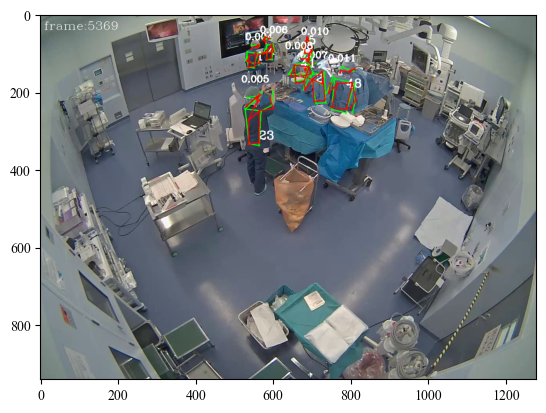

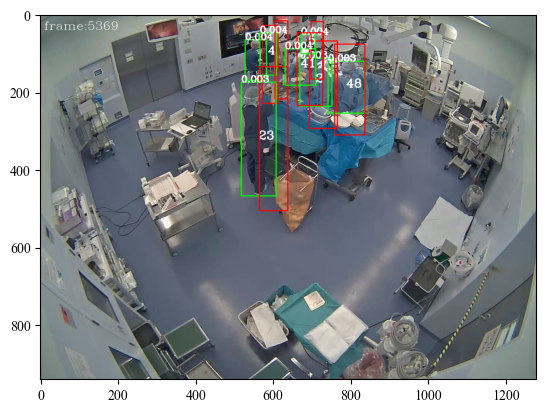

In [6]:
plt.imshow(cv2.cvtColor(frame_kps, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(frame_bbox, cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
# print("mse_x_kps")
# vis.plot_mse(mse_x_dict, max_n_frame, stride, 0.05, "mse", None, True)

# print("mse_x_bbox")
# vis.plot_mse(mse_x_diff_dict, max_n_frame, stride, 0.05, "mse", None, True)

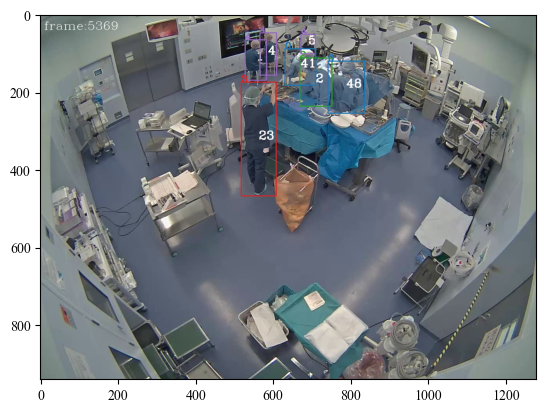

In [8]:
# plot clustering result
plt.imshow(cv2.cvtColor(frame_cluster, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
if not config.mask_leg:
    n_pts = 17 + 2
else:  # mask ankles and knees
    n_pts = 17 - 4 + 2

X = np.array(latent_features["ze"])
X = X.reshape(-1, config.latent_ndim * n_pts * 2)

clustering label


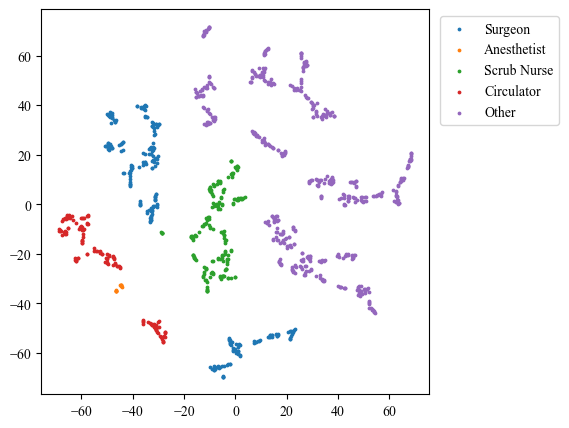

In [10]:
print("clustering label")
labels = np.array(latent_features["label"])
vis.plot_tsne(X, labels, classes, 10, None, True, cmap="tab10")

role


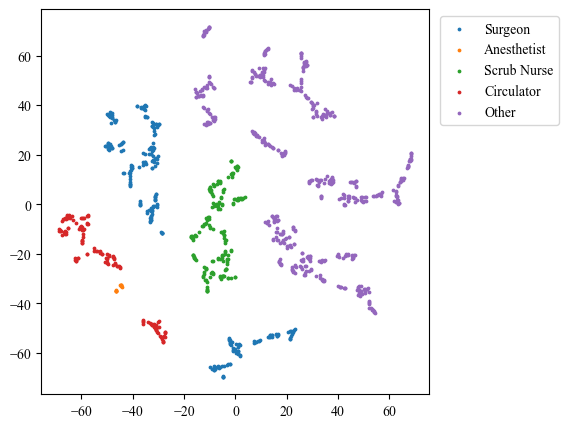

In [11]:
print("role")
annotation = np.loadtxt(f"../datasets/dataset{dataset_num:02d}/annotation/role_train.txt", str, delimiter=" ", skiprows=1)
id2role = {key: int(label) for (key, label) in annotation}

def cvt_key(key):
    video_num, n_Frame, _id = key.split("_")
    return f"{video_num}_{_id}"
keys = np.array([cvt_key(r["key"]) for r in results])
roles = [id2role[k] for k in keys]

vis.plot_tsne(X, roles, classes, 10, None, True, cmap="tab10")

0


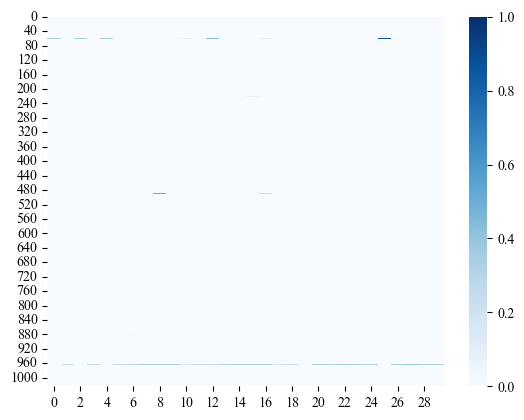

1


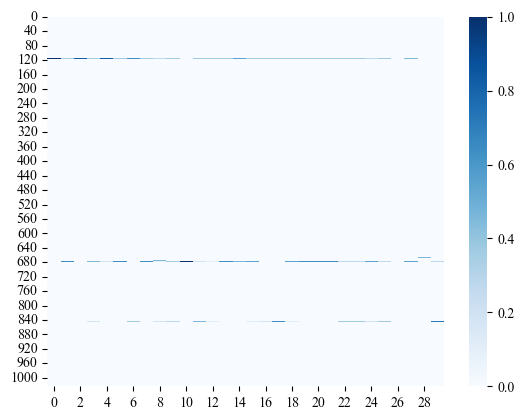

2


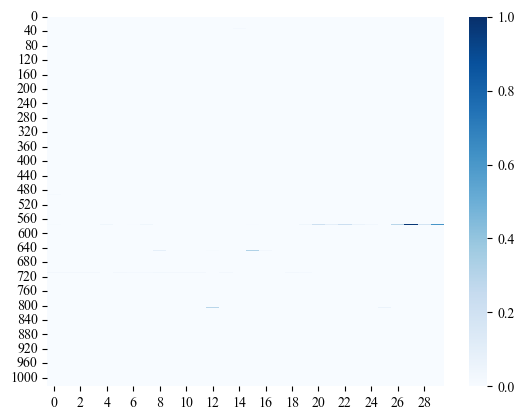

3


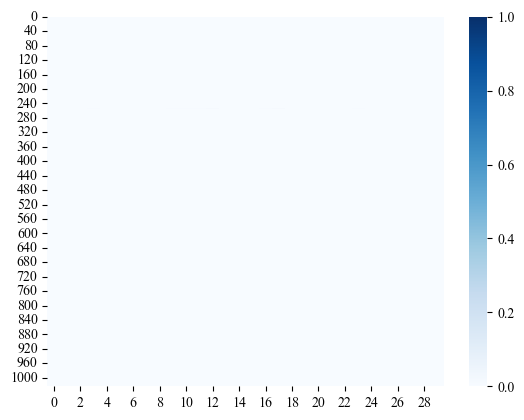

4


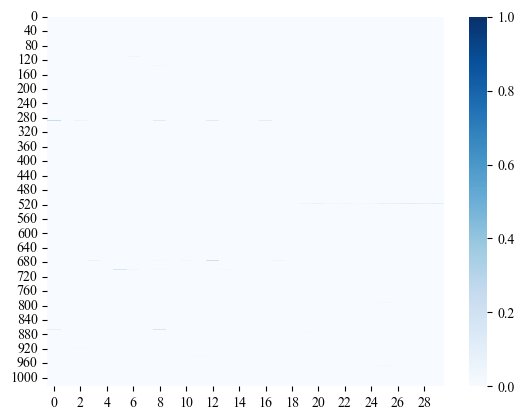

In [12]:
book_idxs = np.array([r["book_idx"] for r in results])
labels = np.array(latent_features["label"])

latent_idx_counts = {
    i: np.array([[0 for k in range(config.book_size)] for j in range(n_pts * 2)])
    for i in range(config.n_clusters)
}
for label, book_idx in zip(labels, book_idxs):
    for j, k in enumerate(book_idx):
        latent_idx_counts[label][j, k] += 1

for label, counts in latent_idx_counts.items():
    print(label)
    cm = np.array(counts).T
    cm = cm / cm.sum(axis=0).reshape(1, -1)
    sns.heatmap(cm, cmap="Blues", vmax=1.0, vmin=0.0)
    plt.show()